# Import

In [69]:
import os, sys
import joblib
import importlib

import pandas as pd
import polars as pl
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import dproc, sgml, sgutil, sgpp

print(sys.version)
for i in [pd, pl, mpl, sns, np]:
    print(i.__name__, i.__version__)

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]
pandas 2.2.3
polars 1.12.0
matplotlib 3.8.4
seaborn 0.13.2
numpy 1.26.4


In [70]:
from datetime import date


from sklearn.pipeline import make_pipeline

# Load Data

In [71]:
data_path = 'data'
files = {
    'train': os.path.join(data_path, 'train.csv'),
    'test': os.path.join(data_path, 'test.csv'),
    'vars': os.path.join(data_path, 'vars.pkl')
}
for i in ['result', 'data', 'model', 'img']:
    if not os.path.isdir(i):
        os.mkdir(i)

sc = sgutil.SGCache('img', 'result')

In [72]:
if (not os.path.isfile(files['train'])) and (not os.path.isfile(files['vars'])):
    !kaggle competitions download -c playground-series-s5e1
    if not os.path.exists(data_path):
        !mkdir data
    !unzip playground-series-s5e1.zip -d data
    !rm playground-series-s5e1.zip

In [73]:
min_dt = date(year = 2010, month = 1, day = 1)
t = sc.cache_result(
    'pl_pipeline',
    lambda : make_pipeline(
        sgpp.PolarsProcessor({'date': pl.Datetime}), 
        sgpp.ExprProcessor({
            'year':  pl.col('date').dt.year(),
            'month':  pl.col('date').dt.month(),
            'day':  pl.col('date').dt.day(),
            'weekday':  pl.col('date').dt.weekday(),
            'days': (pl.col('date') - min_dt).dt.total_days().cast(pl.Int16)
        }),
        sgpp.PandasCoverter(index_col = 'id')
    ).fit(files['train']), rerun = 1
)
df_train = t.transform(files['train'])
df_test = t.transform(files['test'])

In [74]:
df_train.isna().agg(['sum', 'mean'])

,date,country,store,product,num_sold,year,month,day,weekday,days
sum,0.0,0.0,0.0,0.0,8871.000000,0.0,0.0,0.0,0.0,0.0
mean,0.0,0.0,0.0,0.0,0.038548,0.0,0.0,0.0,0.0,0.0


In [75]:
df_test.isna().agg(['sum', 'mean'])

,date,country,store,product,year,month,day,weekday,days
sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
target = 'num_sold'
X_nom = ['country', 'store', 'product', 'weekday', 'month']
X_cat = X_nom
X_num = ['days', 'day']

In [95]:
df_train['date'].agg(['min', 'max']), df_test['date'].agg(['min', 'max'])

(min   2010-01-01
 max   2016-12-31
 Name: date, dtype: datetime64[ns],
 min   2017-01-01
 max   2019-12-31
 Name: date, dtype: datetime64[ns])

# Target

In [81]:
df_train[target].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
num_sold,221259.0,752.527405,690.165466,5.0,219.0,605.0,1114.0,5939.0


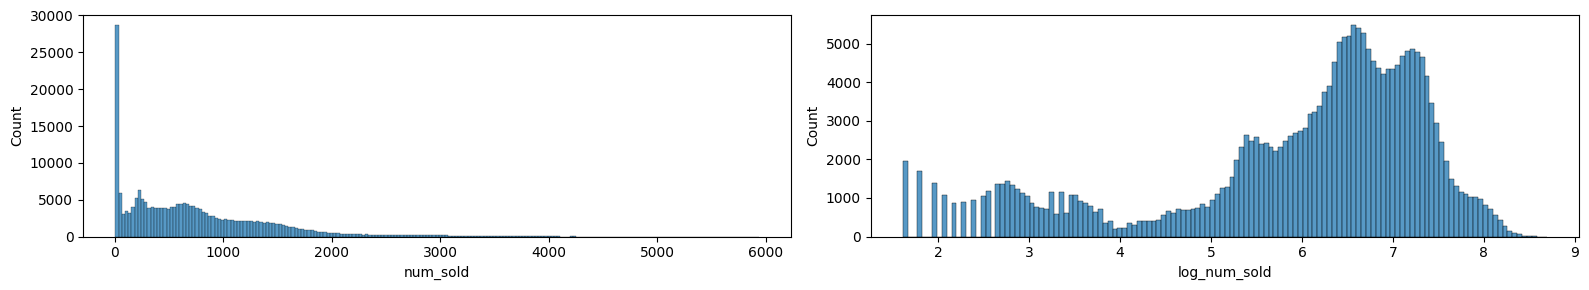

In [85]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(
    df_train[target] , ax = axes[0]
)

sns.histplot(
    np.log(df_train[target]).rename('log_num_sold') , ax = axes[1]
)
plt.tight_layout()
plt.show()

In [103]:
df_train['date'].value_counts().unique()

array([90])

In [112]:
df_train.groupby('date')[target].agg(lambda x: x.isna().sum()).rename('na_cnt_by_date').value_counts().rename('count of na_cnt_by_date').to_frame().T

na_cnt_by_date,3,2,4,5,6,7
count of na_cnt_by_date,748,679,534,447,145,4


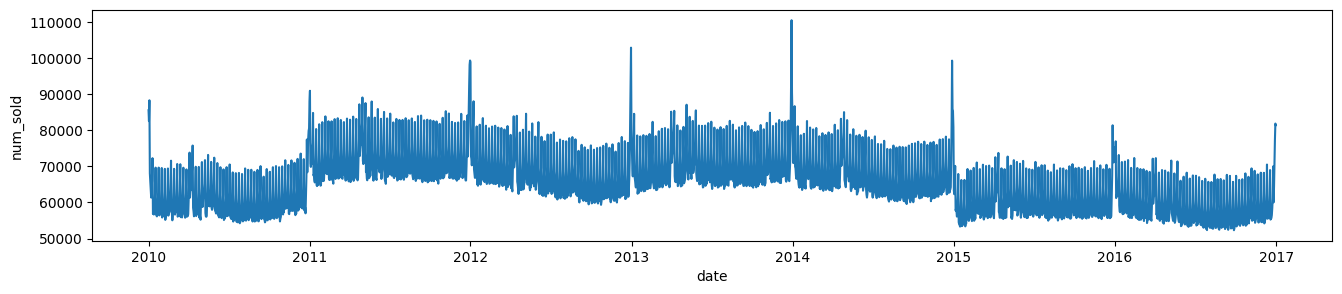

In [125]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby('date')[target].agg(lambda x: x.sort_values(ascending = False).iloc[:-6].sum())
)
plt.show()

# Categorical Variables

In [89]:
df_train[X_cat].apply(lambda x: x.nunique()).rename('nunique').to_frame().T

,country,store,product,weekday,month
nunique,6,3,5,7,12


In [94]:
for i in X_cat:
    display(df_train[i].value_counts().to_frame().T)

country,Canada,Finland,Italy,Kenya,Norway,Singapore
count,38355,38355,38355,38355,38355,38355


store,Discount Stickers,Stickers for Less,Premium Sticker Mart
count,76710,76710,76710


product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
count,46026,46026,46026,46026,46026


weekday,5,6,7,1,2,3,4
count,32940,32940,32850,32850,32850,32850,32850


month,1,3,5,7,8,10,12,4,6,9,11,2
count,19530,19530,19530,19530,19530,19530,19530,18900,18900,18900,18900,17820


In [135]:
from scipy.stats import chi2_contingency
df_train[X_cat].apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns = df_train[target].isna())).pvalue
)

country    0.000000e+00
store      0.000000e+00
product    0.000000e+00
weekday    8.483659e-44
month      6.909299e-79
dtype: float64

In [141]:
pd.crosstab(index = df_train['country'], columns = df_train[target].isna()).T

country,Canada,Finland,Italy,Kenya,Norway,Singapore
num_sold,,,,,,
False,34109,38355,38355,33730,38355,38355
True,4246,0,0,4625,0,0


In [142]:
pd.crosstab(index = df_train['product'], columns = df_train[target].isna()).T

product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
num_sold,,,,,
False,37220,46026,46026,45962,46025
True,8806,0,0,64,1


In [143]:
pd.crosstab(index = df_train['store'], columns = df_train[target].isna()).T

store,Discount Stickers,Stickers for Less,Premium Sticker Mart
num_sold,,,
False,71531,74044,75684
True,5179,2666,1026


In [147]:
df_train.loc[(df_train['country'] == 'Canada') & (df_train[target].isna()), ['store', 'product']].value_counts()

store                 product          
Discount Stickers     Holographic Goose    2557
Stickers for Less     Holographic Goose    1308
Premium Sticker Mart  Holographic Goose     380
Discount Stickers     Kerneler                1
Name: count, dtype: int64

In [158]:
df_train.loc[(df_train['country'] == 'Kenya') & (df_train[target].isna()), ['store', 'product']].value_counts()

store                 product           
Discount Stickers     Holographic Goose     2557
Stickers for Less     Holographic Goose     1358
Premium Sticker Mart  Holographic Goose      646
Discount Stickers     Kerneler                63
                      Kerneler Dark Mode       1
Name: count, dtype: int64

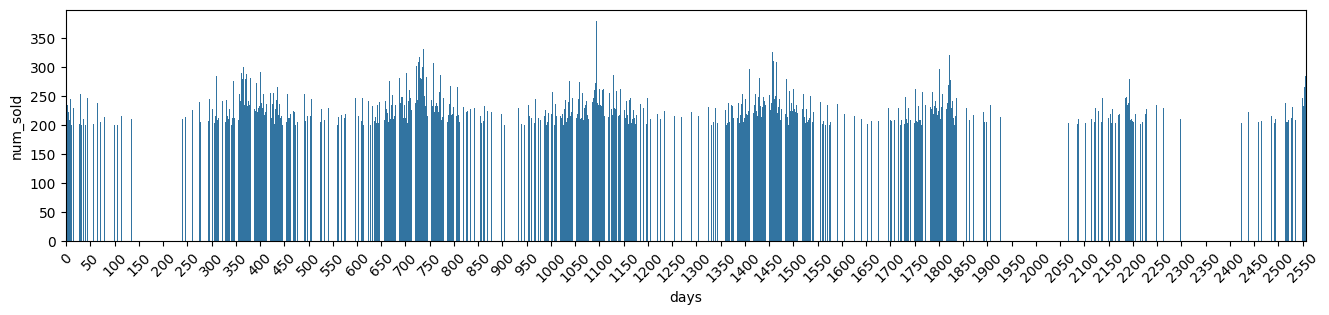

In [181]:
plt.figure(figsize = (16, 3))
sns.barplot(
    df_train.loc[(df_train['country'].isin(['Canada'])) & (df_train['product'] == "Holographic Goose") & (df_train['store'] == "Stickers for Less")],
    x = 'days', y = target
)
xticks = plt.gca().get_xticks() 
xtick_labels = plt.gca().get_xticklabels()  # 현재 x축 레이블 가져오기
# 일부 레이블만 표시
plt.xticks(xticks[::50], [label.get_text() for label in xtick_labels][::50], rotation=45) 
plt.show()

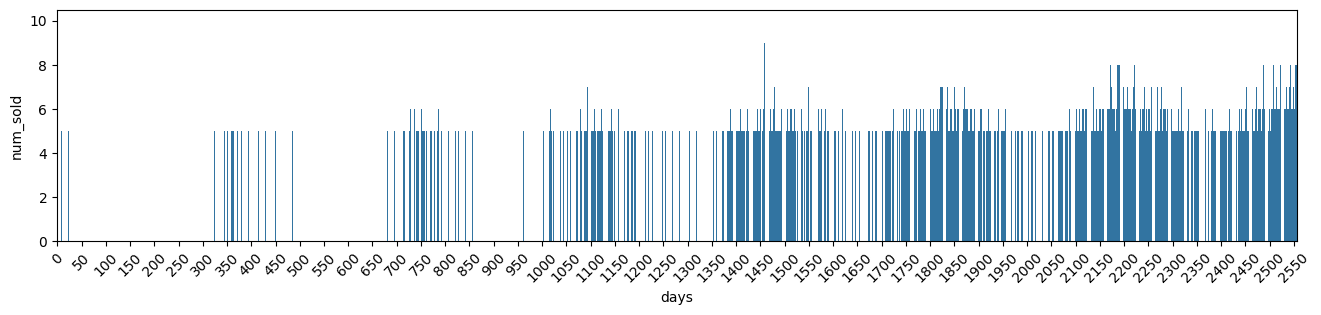

In [182]:
plt.figure(figsize = (16, 3))
sns.barplot(
    df_train.loc[(df_train['country'].isin(['Kenya'])) & (df_train['product'] == "Holographic Goose") & (df_train['store'] == "Stickers for Less")],
    x = 'days', y = target
)
xticks = plt.gca().get_xticks() 
xtick_labels = plt.gca().get_xticklabels()  # 현재 x축 레이블 가져오기
# 일부 레이블만 표시
plt.xticks(xticks[::50], [label.get_text() for label in xtick_labels][::50], rotation=45) 
plt.show()

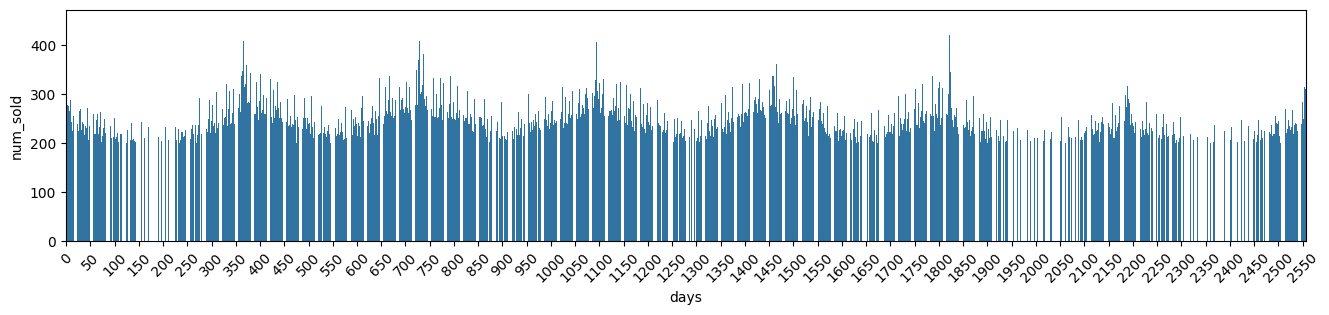

In [183]:
plt.figure(figsize = (16, 3))
sns.barplot(
    df_train.loc[(df_train['country'].isin(['Canada'])) & (df_train['product'] == "Holographic Goose") & (df_train['store'] == "Premium Sticker Mart")],
    x = 'days', y = target
)
xticks = plt.gca().get_xticks() 
xtick_labels = plt.gca().get_xticklabels()  # 현재 x축 레이블 가져오기
# 일부 레이블만 표시
plt.xticks(xticks[::50], [label.get_text() for label in xtick_labels][::50], rotation=45) 
plt.show()

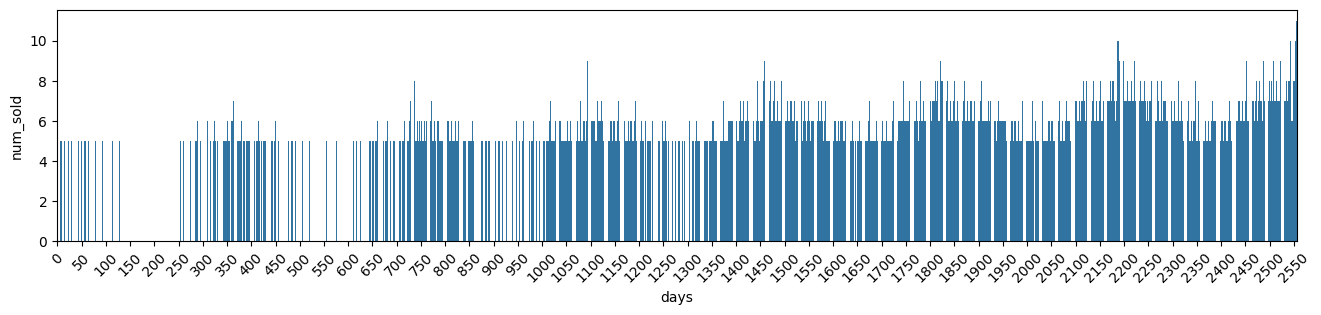

In [184]:
plt.figure(figsize = (16, 3))
sns.barplot(
    df_train.loc[(df_train['country'].isin(['Kenya'])) & (df_train['product'] == "Holographic Goose") & (df_train['store'] == "Premium Sticker Mart")],
    x = 'days', y = target
)
xticks = plt.gca().get_xticks() 
xtick_labels = plt.gca().get_xticklabels()  # 현재 x축 레이블 가져오기
# 일부 레이블만 표시
plt.xticks(xticks[::50], [label.get_text() for label in xtick_labels][::50], rotation=45) 
plt.show()

In [187]:
df_train.loc[(df_train['product'] == 'Kerneler Dark Mode') & df_train[target].isna()]

,date,country,store,product,num_sold,year,month,day,weekday,days
id,,,,,,,,,,
23719,2010-09-21,Kenya,Discount Stickers,Kerneler Dark Mode,NaN,2010,9,21,2,263


In [191]:
df_train.loc[(df_train['product'] == 'Kerneler Dark Mode') & (df_train['country'] == 'Kenya') & df_train['days'].isin([262, 264])]

,date,country,store,product,num_sold,year,month,day,weekday,days
id,,,,,,,,,,
23629,2010-09-20,Kenya,Discount Stickers,Kerneler Dark Mode,5.0,2010,9,20,1,262
23634,2010-09-20,Kenya,Stickers for Less,Kerneler Dark Mode,10.0,2010,9,20,1,262
23639,2010-09-20,Kenya,Premium Sticker Mart,Kerneler Dark Mode,13.0,2010,9,20,1,262
23809,2010-09-22,Kenya,Discount Stickers,Kerneler Dark Mode,5.0,2010,9,22,3,264
23814,2010-09-22,Kenya,Stickers for Less,Kerneler Dark Mode,11.0,2010,9,22,3,264
23819,2010-09-22,Kenya,Premium Sticker Mart,Kerneler Dark Mode,13.0,2010,9,22,3,264


In [203]:
df_train.loc[df_train['product'] == 'Kerneler Dark Mode', target] = df_train.loc[df_train['product'] == 'Kerneler Dark Mode', target].fillna(5)
df_train.loc[(df_train['product'] == 'Kerneler'), target] = \
    df_train.loc[(df_train['product'] == 'Kerneler')].groupby(['country', 'store'], observed = False)[target].transform(
        lambda x: x.interpolate()
    )

In [204]:
df_train.groupby('date')[target].agg(lambda x: x.isna().sum()).rename('na_cnt_by_date').value_counts().rename('count of na_cnt_by_date').to_frame().T

na_cnt_by_date,3,2,4,5,6
count of na_cnt_by_date,751,679,547,473,107


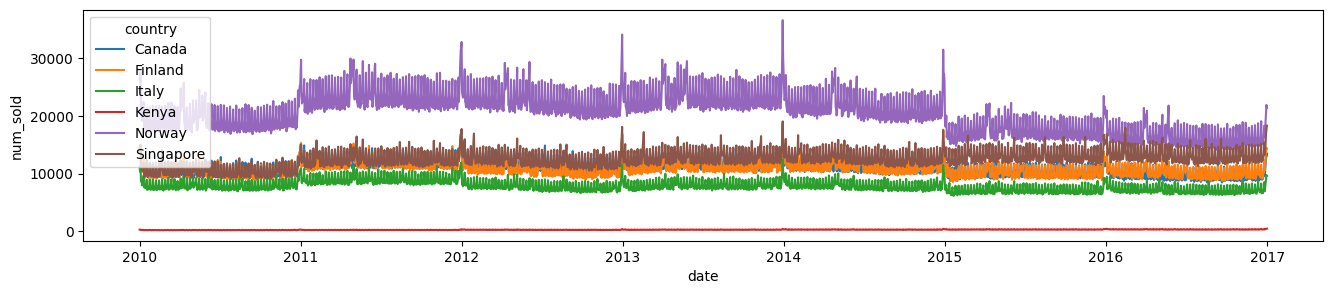

In [127]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby(['date', 'country'], as_index = False, observed=False)[target].agg(lambda x: x.sort_values(ascending = False).iloc[:-3].sum()), 
    x = 'date', y = 'num_sold', hue = 'country'
)
plt.show()

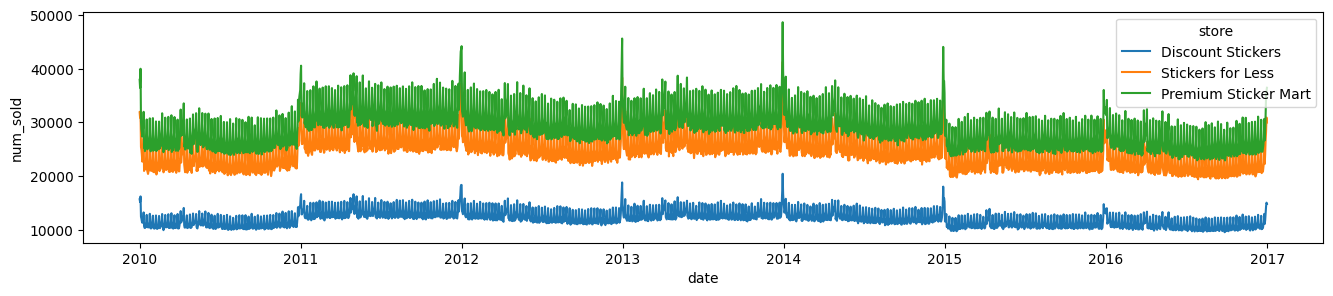

In [128]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby(['date', 'store'], as_index = False, observed=False)[target].agg(lambda x: x.sort_values(ascending = False).iloc[:-3].sum()), 
    x = 'date', y = 'num_sold', hue = 'store'
)
plt.show()

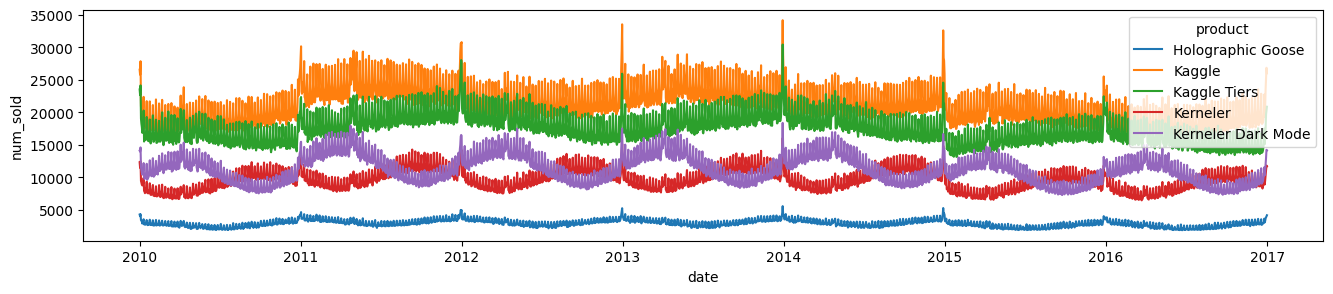

In [130]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby(['date', 'product'], as_index = False, observed=False)[target].agg(lambda x: x.sort_values(ascending = False).iloc[:-5].sum()), 
    x = 'date', y = 'num_sold', hue = 'product'
)
plt.show()

In [207]:
df_train.loc[df_train['product'] != 'Holographic Goose', target].isna().sum()

0

In [208]:
df_train.loc[~df_train['country'].isin(['Canada', 'Kenya']), target].isna().sum()

0

In [221]:
df_ratio_product = df_train.loc[~df_train['country'].isin(['Canada', 'Kenya'])].pipe(
    lambda x: x.pivot_table(index = x['days'], columns = x['product'], values=target, aggfunc = 'sum', observed = True)
).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
df_ratio_product.head()

product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
days,,,,,
0,0.052199,0.329210,0.289181,0.154402,0.175008
1,0.051393,0.331010,0.290622,0.148871,0.178105
2,0.051953,0.332878,0.289431,0.150612,0.175125
3,0.052749,0.325723,0.297911,0.146376,0.177240
4,0.051869,0.329591,0.290967,0.147771,0.179801


In [222]:
df_ratio_country = df_train.loc[df_train['product'] != 'Holographic Goose'].pipe(
    lambda x: x.pivot_table(index = x['days'], columns = x['country'], values=target, aggfunc = 'sum', observed = True)
).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
df_ratio_country.head()

country,Canada,Finland,Italy,Kenya,Norway,Singapore
days,,,,,,
0,0.177600,0.178992,0.135909,0.003460,0.325773,0.178265
1,0.181301,0.173870,0.131336,0.003505,0.328672,0.181314
2,0.178494,0.175288,0.135738,0.003468,0.328460,0.178553
3,0.175085,0.174729,0.133957,0.003514,0.334303,0.178413
4,0.175983,0.177955,0.139273,0.003543,0.326975,0.176272


In [223]:
df_ratio_store = df_train.loc[(df_train['product'] != 'Holographic Goose') & ~df_train['country'].isin(['Canada', 'Kenya'])].pipe(
    lambda x: x.pivot_table(index = x['days'], columns = x['store'], values=target, aggfunc = 'sum', observed = True)
).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
df_ratio_store.head()

store,Discount Stickers,Stickers for Less,Premium Sticker Mart
days,,,
0,0.182737,0.373427,0.443836
1,0.185237,0.373569,0.441194
2,0.185028,0.359058,0.455913
3,0.182531,0.375596,0.441873
4,0.185612,0.380036,0.434352


In [237]:
df_ratio = pd.DataFrame(
    0,
    columns = pd.MultiIndex.from_product(df_train[X_cat[:3]].apply(lambda x: x.unique().tolist())),
    index = df_train['days'].unique()
).apply(
    lambda x: df_ratio_country.loc[:, x.name[0]] * df_ratio_store.loc[:, x.name[1]] * df_ratio_product.loc[:, x.name[2]]
)
df_ratio.head()

Canada                                                      \
     Discount Stickers                                                       
     Holographic Goose    Kaggle Kaggle Tiers  Kerneler Kerneler Dark Mode   
days                                                                         
0             0.001694  0.010684     0.009385  0.005011           0.005680   
1             0.001726  0.011117     0.009760  0.005000           0.005981   
2             0.001716  0.010994     0.009559  0.004974           0.005784   
3             0.001686  0.010410     0.009521  0.004678           0.005664   
4             0.001694  0.010766     0.009504  0.004827           0.005873   

                                                                            \
     Stickers for Less                                                       
     Holographic Goose    Kaggle Kaggle Tiers  Kerneler Kerneler Dark Mode   
days                                                                         
0             0.003462  0.021833     0.019179  0.010240           0.011607   
1             0.003481  0.022419     0.019683  0.010083           0.012063   
2             0.003330  0.021334     0.018550  0.009653           0.011224   
3             0.003469  0.021420     0.019591  0.009626           0.011656   
4             0.003469  0.022043     0.019460  0.009883           0.012025   

      ...         Singapore                                   \
      ... Stickers for Less                                    
      ... Holographic Goose    Kaggle Kaggle Tiers  Kerneler   
days  ...                                                      
0     ...          0.003475  0.021915     0.019251  0.010278   
1     ...          0.003481  0.022420     0.019685  0.010084   
2     ...          0.003331  0.021341     0.018556  0.009656   
3     ...          0.003535  0.021827     0.019963  0.009809   
4     ...          0.003475  0.022079     0.019492  0.009899   

                                                                               \
                        Premium Sticker Mart                                    
     Kerneler Dark Mode    Holographic Goose    Kaggle Kaggle Tiers  Kerneler   
days                                                                            
0              0.011650             0.004130  0.026047     0.022880  0.012216   
1              0.012064             0.004111  0.026479     0.023248  0.011909   
2              0.011227             0.004229  0.027098     0.023561  0.012261   
3              0.011877             0.004159  0.025679     0.023486  0.011540   
4              0.012045             0.003971  0.025235     0.022278  0.011314   

                         
                         
     Kerneler Dark Mode  
days                     
0              0.013847  
1              0.014247  
2              0.014256  
3              0.013973  
4              0.013766  

[5 rows x 90 columns]

In [251]:
df_ratio_notna = pd.DataFrame(
    df_ratio.values * df_train.assign(target_notna = lambda x: x[target].notna()).pivot(
        index = 'days', columns = X_cat[:3], values = 'target_notna'
    ).values, index = df_ratio.index, columns = df_ratio.columns
)
df_ratio_notna.head()

Canada                                                      \
     Discount Stickers                                                       
     Holographic Goose    Kaggle Kaggle Tiers  Kerneler Kerneler Dark Mode   
days                                                                         
0                  0.0  0.010684     0.009385  0.005011           0.005680   
1                  0.0  0.011117     0.009760  0.005000           0.005981   
2                  0.0  0.010994     0.009559  0.004974           0.005784   
3                  0.0  0.010410     0.009521  0.004678           0.005664   
4                  0.0  0.010766     0.009504  0.004827           0.005873   

                                                                            \
     Stickers for Less                                                       
     Holographic Goose    Kaggle Kaggle Tiers  Kerneler Kerneler Dark Mode   
days                                                                         
0             0.003462  0.021833     0.019179  0.010240           0.011607   
1             0.003481  0.022419     0.019683  0.010083           0.012063   
2             0.003330  0.021334     0.018550  0.009653           0.011224   
3             0.003469  0.021420     0.019591  0.009626           0.011656   
4             0.003469  0.022043     0.019460  0.009883           0.012025   

      ...         Singapore                                   \
      ... Stickers for Less                                    
      ... Holographic Goose    Kaggle Kaggle Tiers  Kerneler   
days  ...                                                      
0     ...          0.003475  0.021915     0.019251  0.010278   
1     ...          0.003481  0.022420     0.019685  0.010084   
2     ...          0.003331  0.021341     0.018556  0.009656   
3     ...          0.003535  0.021827     0.019963  0.009809   
4     ...          0.003475  0.022079     0.019492  0.009899   

                                                                               \
                        Premium Sticker Mart                                    
     Kerneler Dark Mode    Holographic Goose    Kaggle Kaggle Tiers  Kerneler   
days                                                                            
0              0.011650             0.004130  0.026047     0.022880  0.012216   
1              0.012064             0.004111  0.026479     0.023248  0.011909   
2              0.011227             0.004229  0.027098     0.023561  0.012261   
3              0.011877             0.004159  0.025679     0.023486  0.011540   
4              0.012045             0.003971  0.025235     0.022278  0.011314   

                         
                         
     Kerneler Dark Mode  
days                     
0              0.013847  
1              0.014247  
2              0.014256  
3              0.013973  
4              0.013766  

[5 rows x 90 columns]

In [257]:
s_est_daily_sum = df_train.groupby('days')[target].sum() * 1 / df_ratio_notna.sum(axis = 1)
s_est_daily_sum.head()

days
0    85714.031250
1    82693.492188
2    88482.773438
3    68197.023438
4    65831.382812
dtype: float32

In [268]:
df_train.loc[df_train[target].isna(), target] = df_train.loc[df_train[target].isna()].apply(
    lambda x: df_ratio.loc[x['days'], tuple(x[X_cat[:3]])] * s_est_daily_sum.loc[x['days']], axis = 1
)

In [270]:
df_train[target].isna().sum()

0

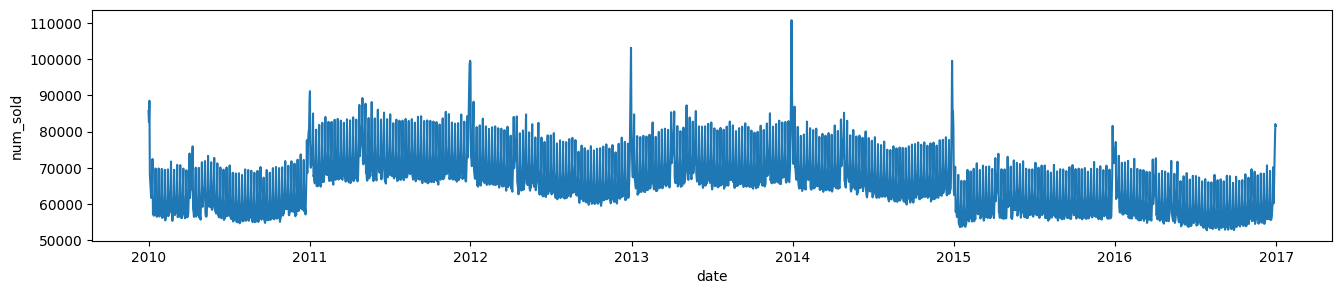

In [271]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby('date')[target].sum()
)
plt.show()